In [1]:
import numpy as np
import os,sys


sys.path.append('../..')
sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/AAS_TEST/RUN/AAS-18-290_6DOF_journal/Run/Run_4km_terminal


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Load Policy

6dof dynamics model
Quaternion_attitude
Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Reward_terminal
queue fixed
Flat Constraint
Attitude Constraint


<IPython.core.display.Javascript object>


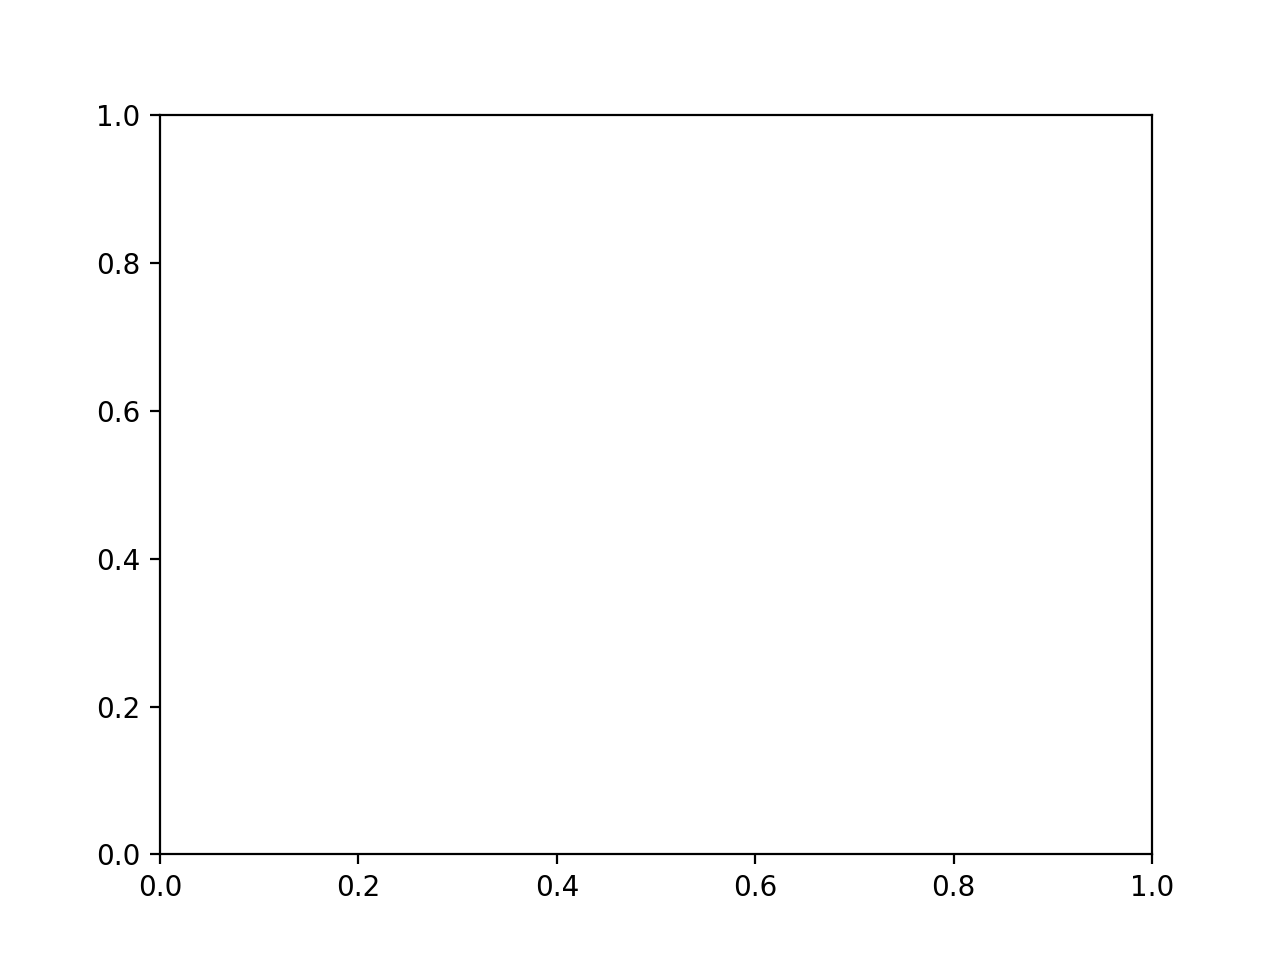

<IPython.core.display.Javascript object>


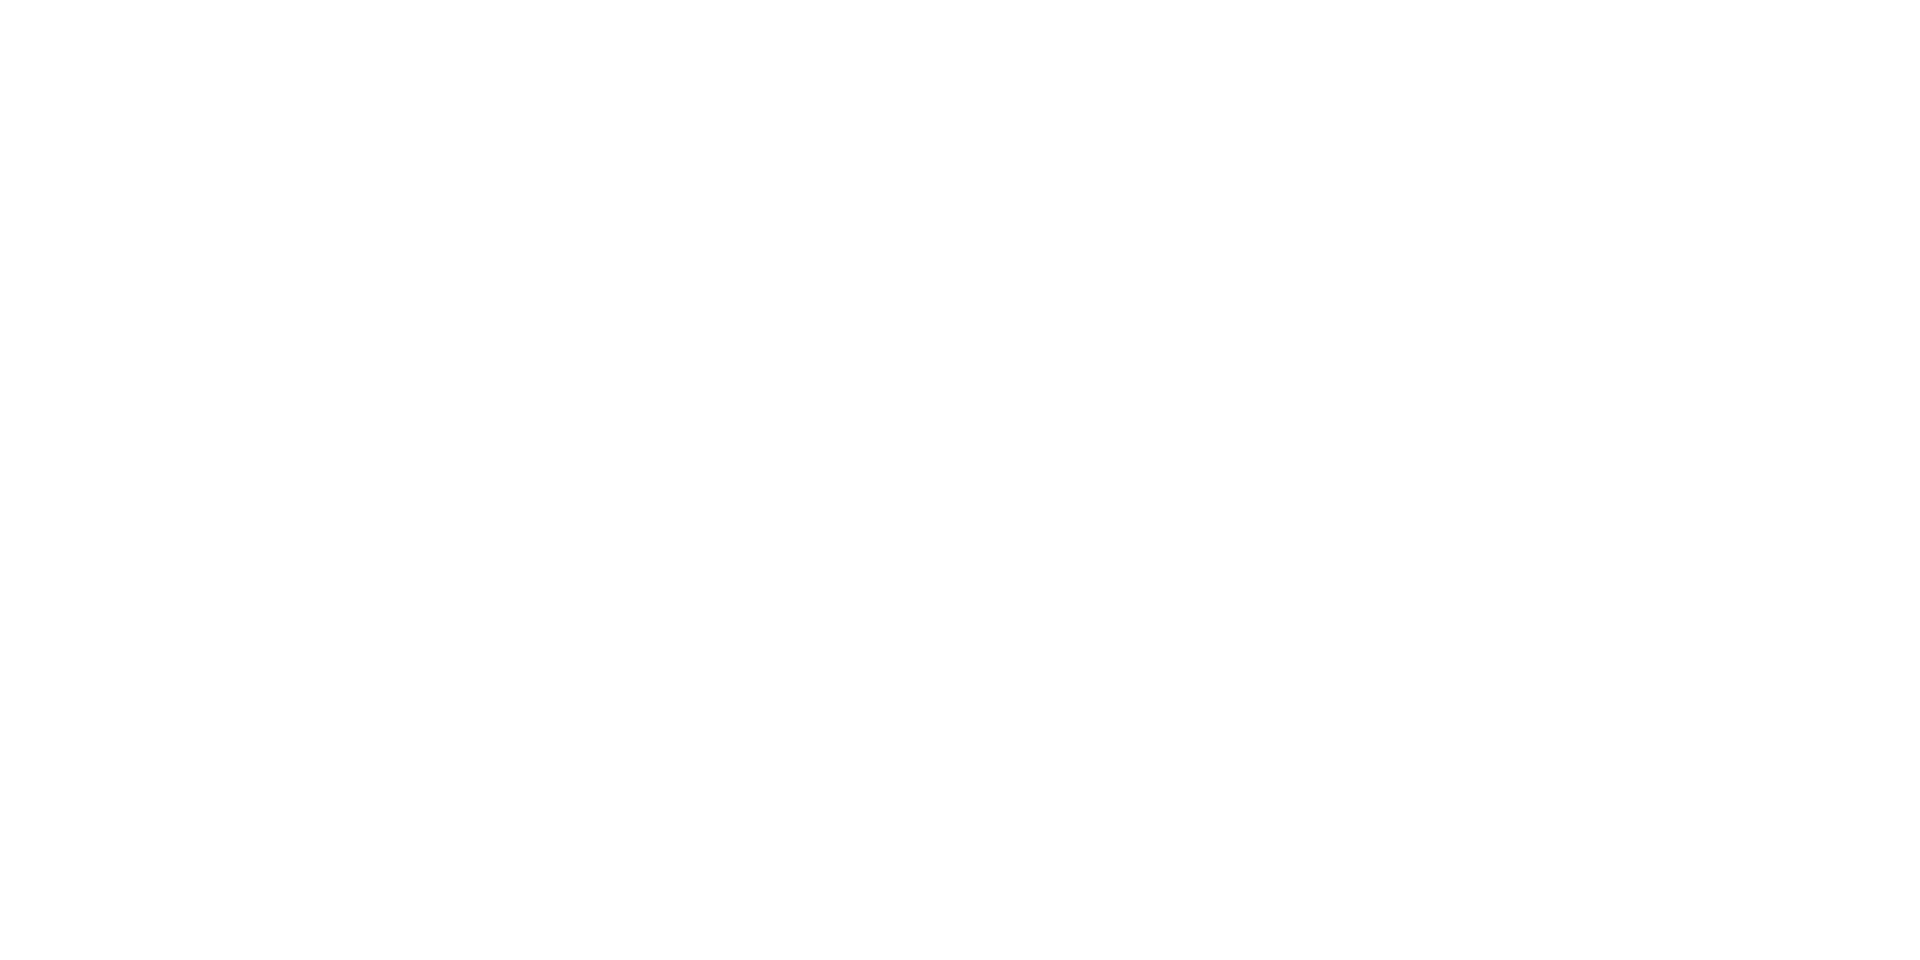

<IPython.core.display.Javascript object>


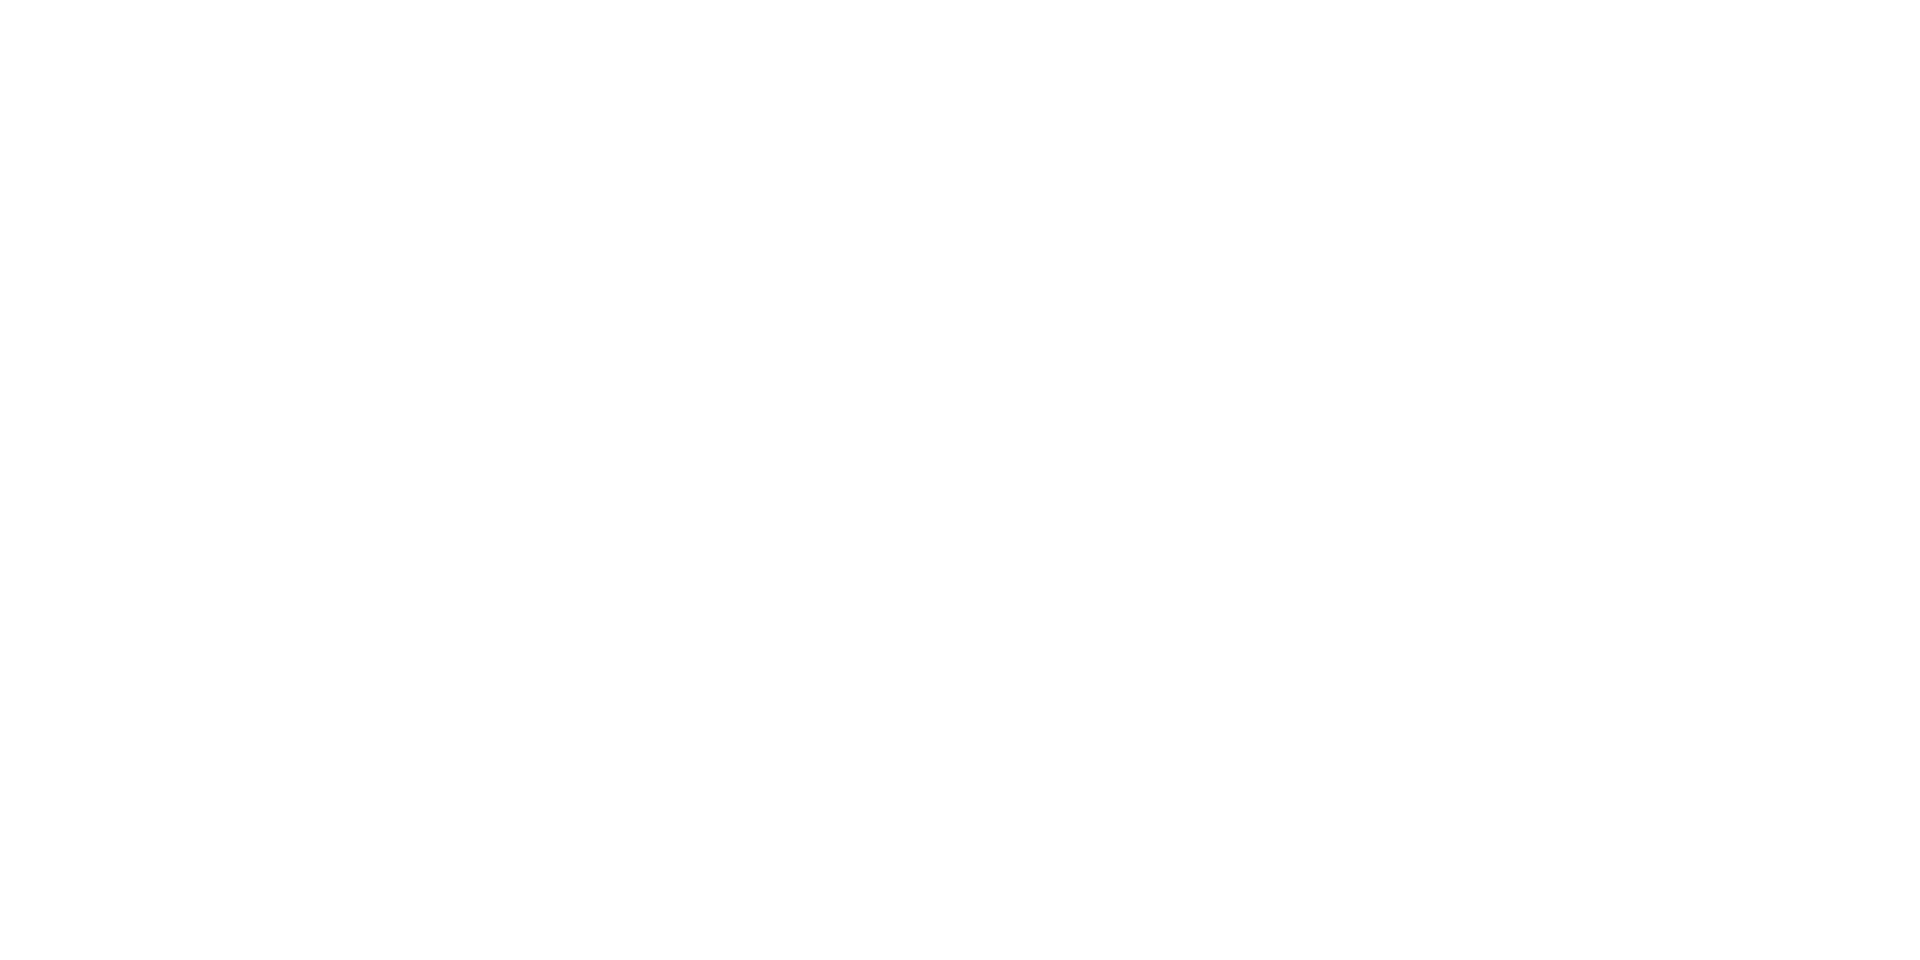

<IPython.core.display.Javascript object>


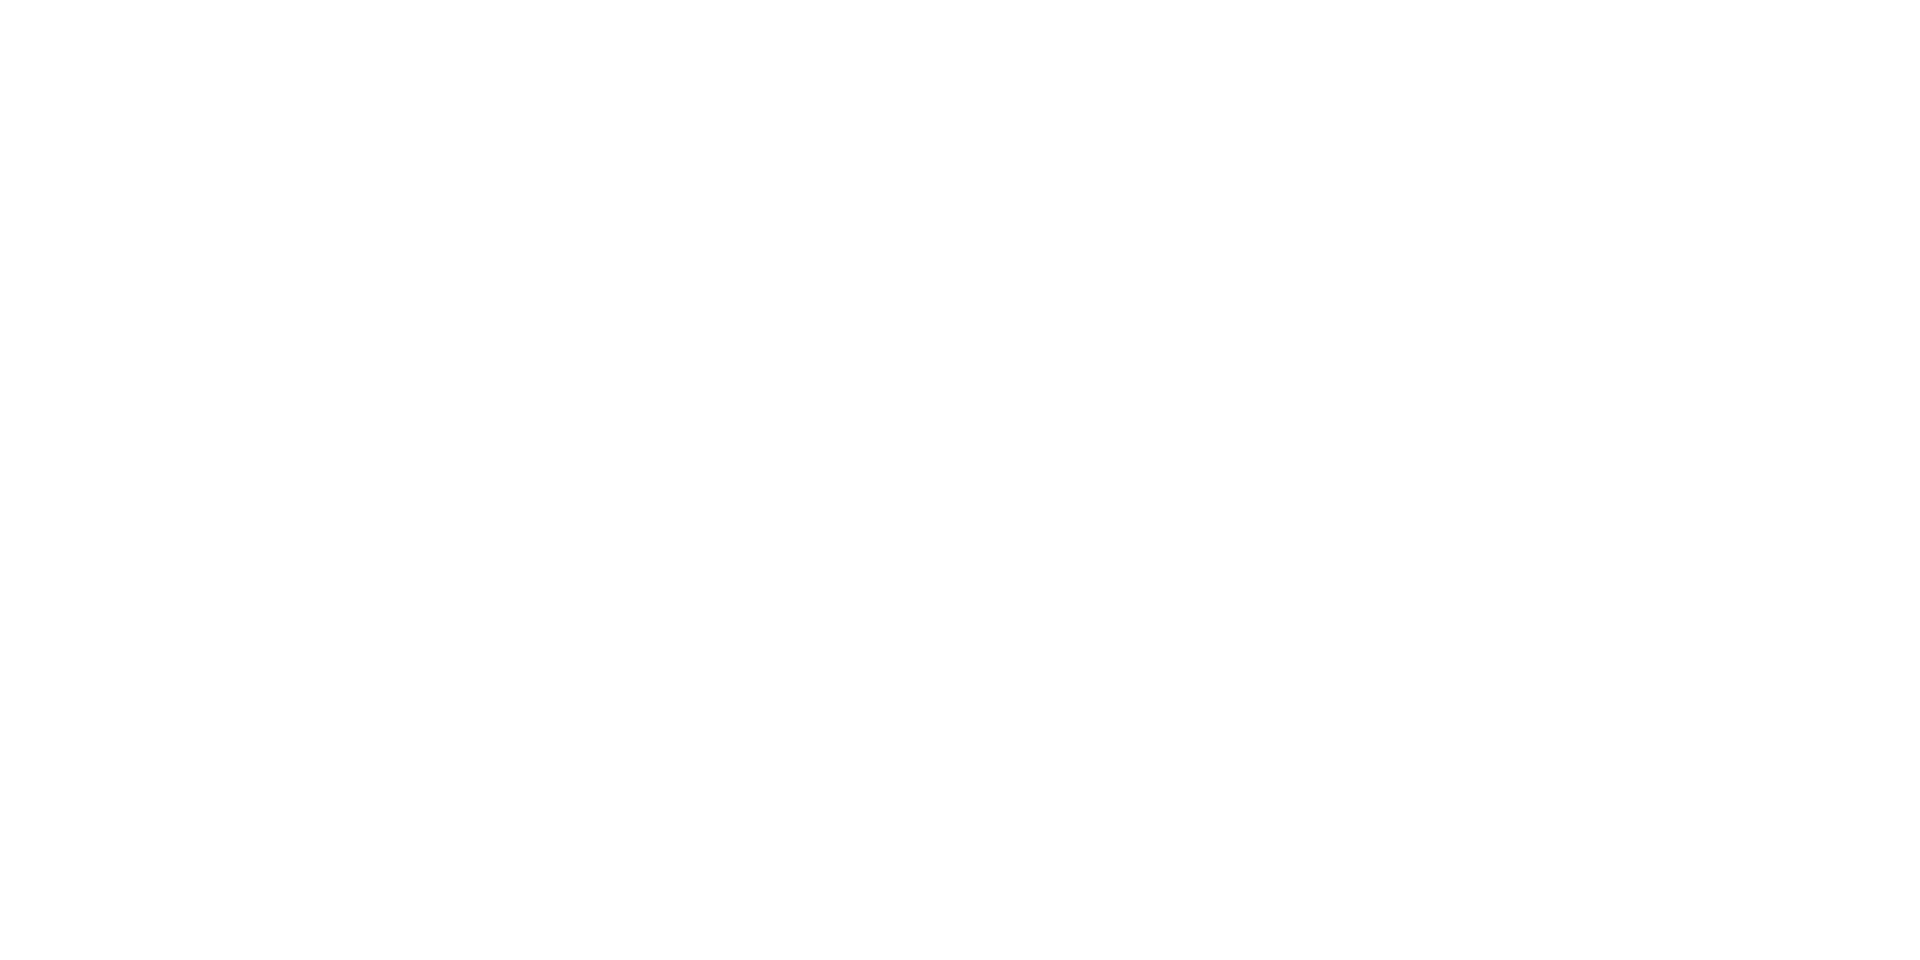

<IPython.core.display.Javascript object>


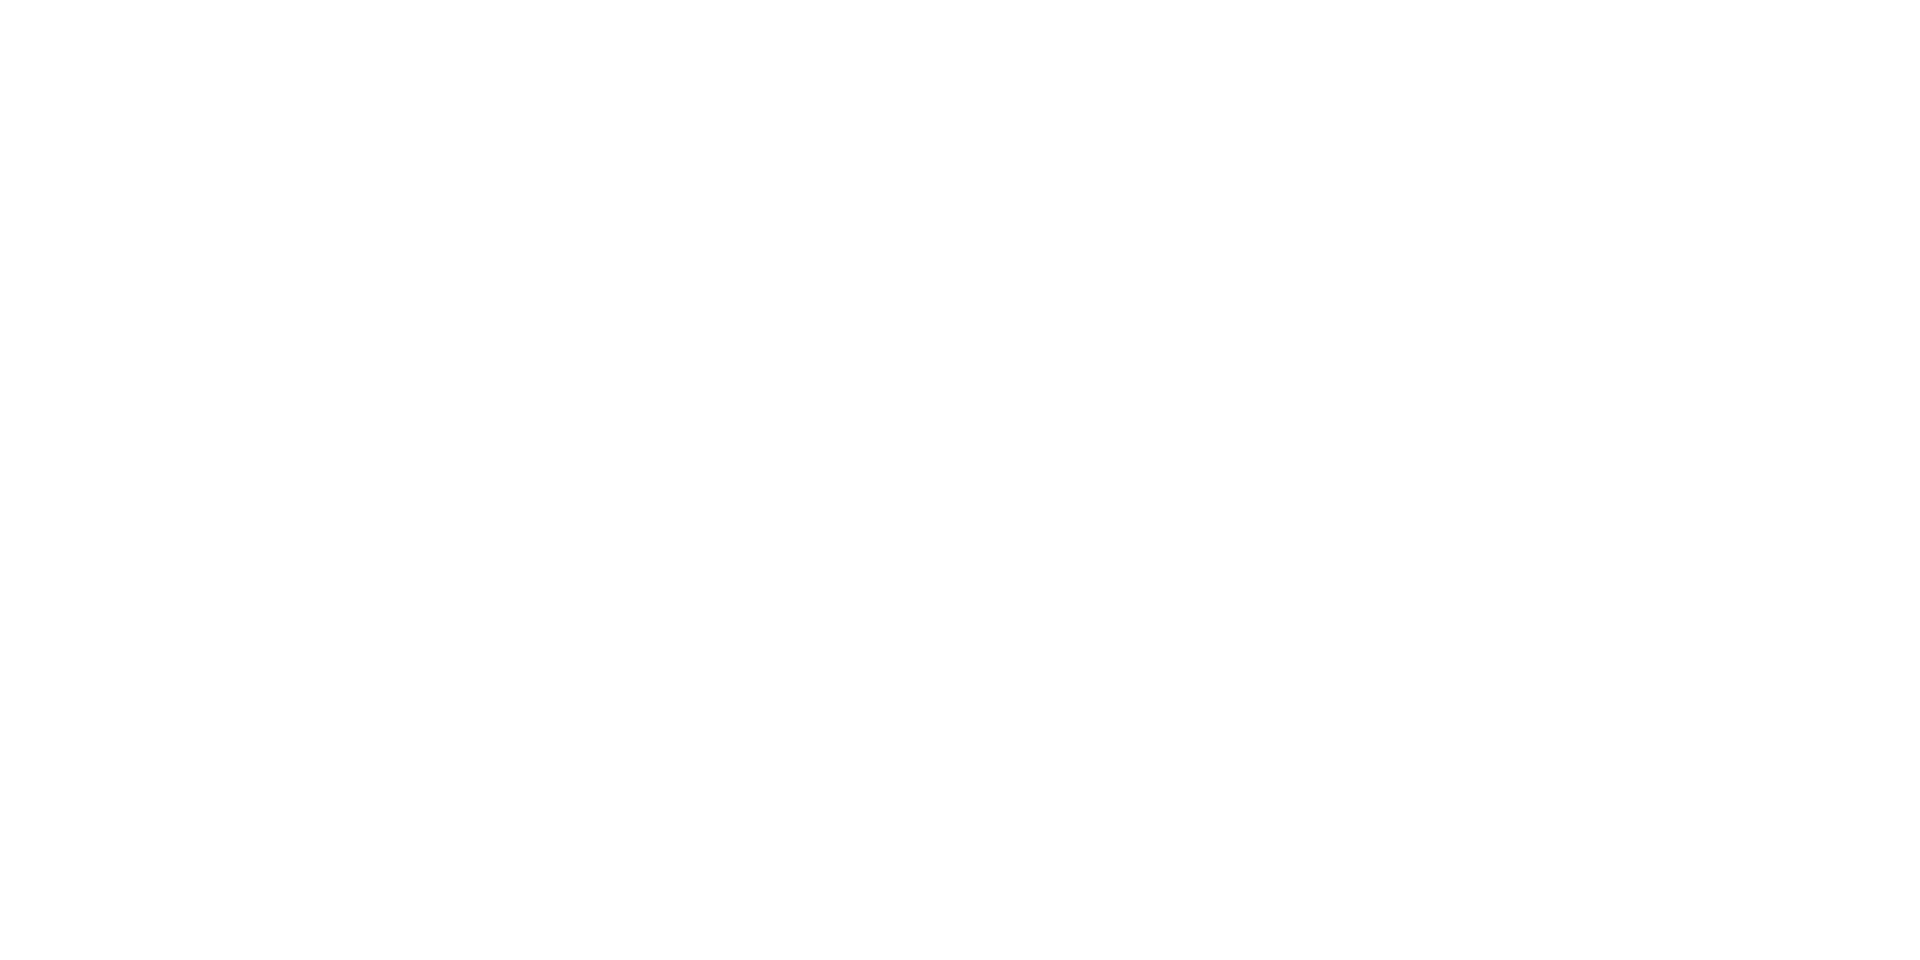

<IPython.core.display.Javascript object>


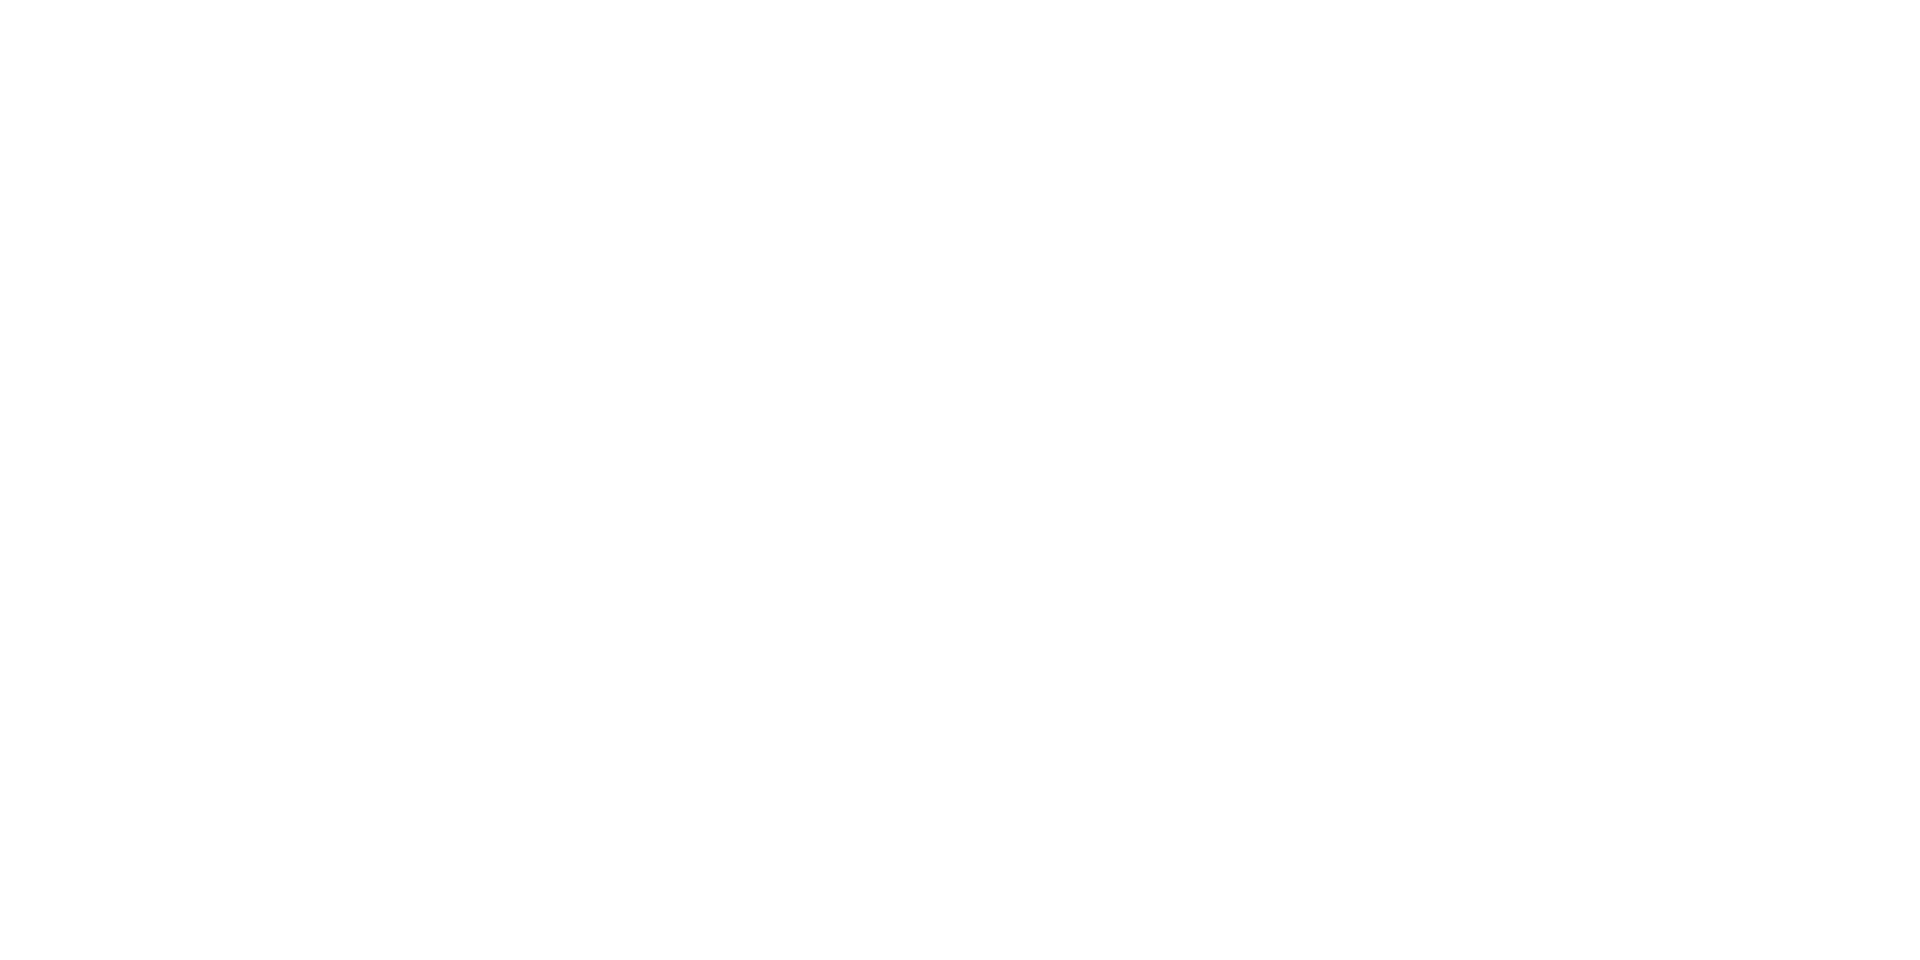

<IPython.core.display.Javascript object>


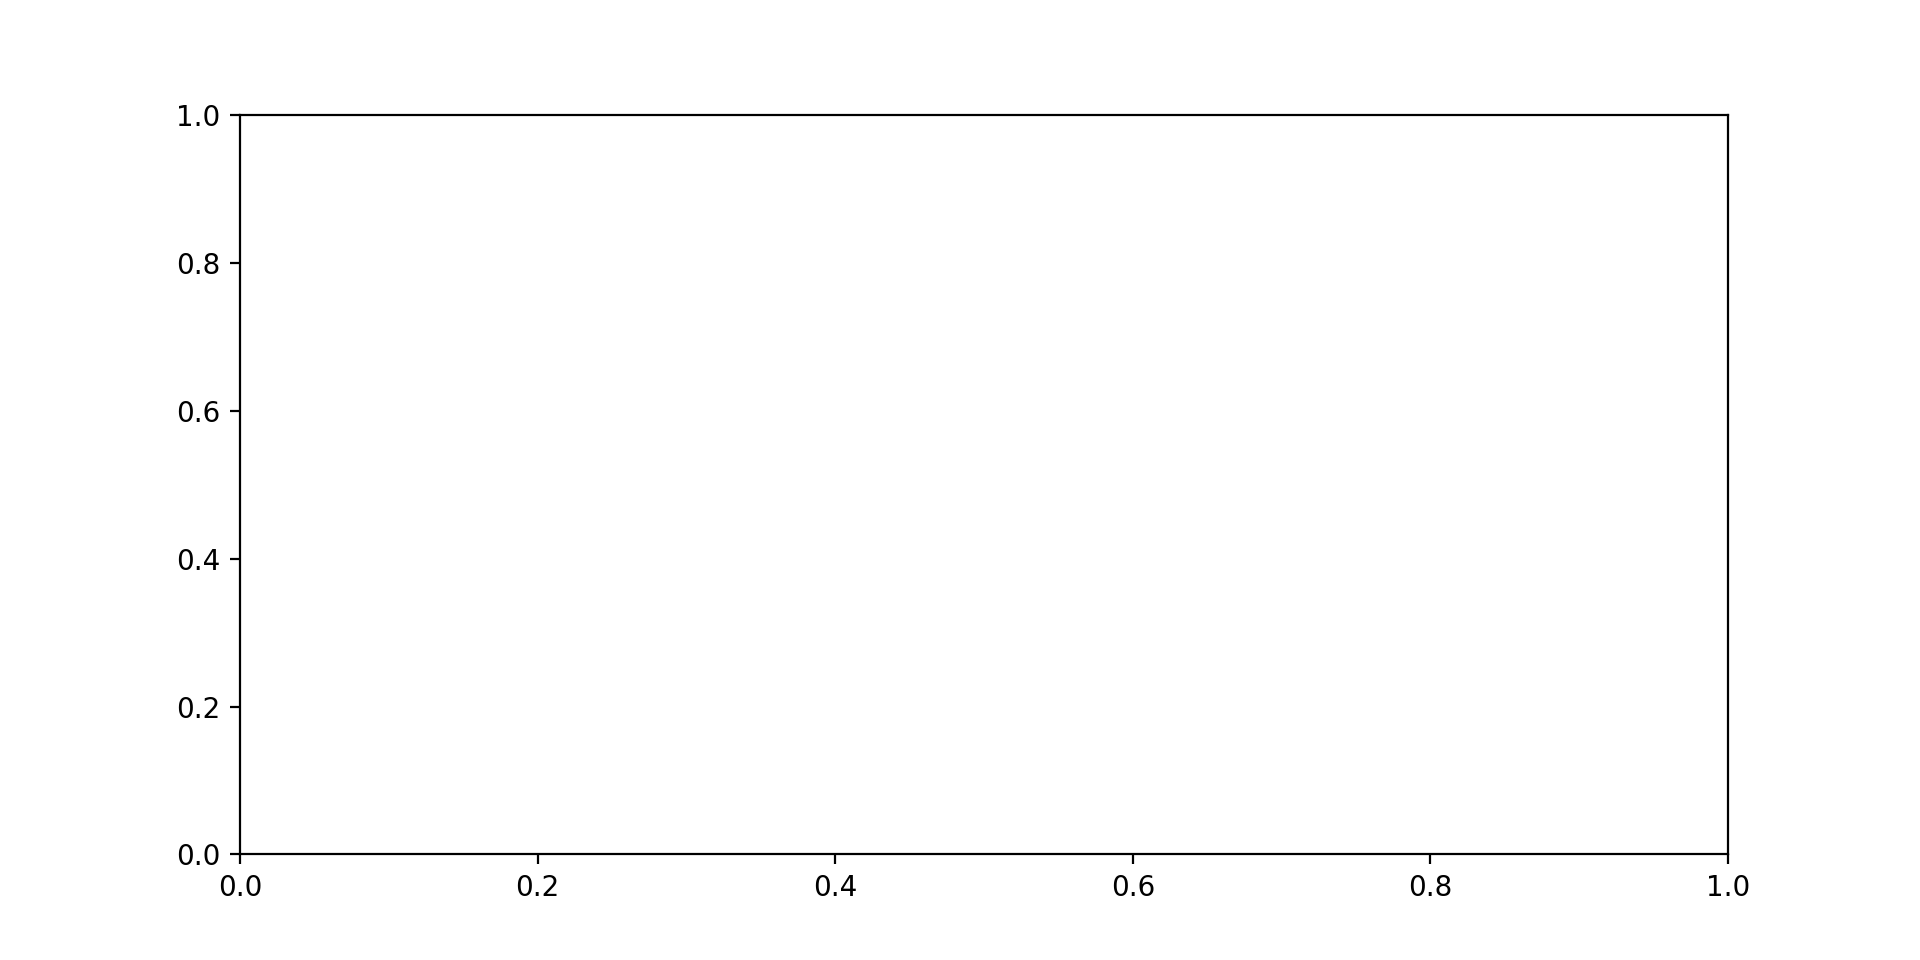

lander env att 2 fixed
Landing_icgen:
    downrange                   :  (0, 2000, -70, -10)
    crossrange                  :  (-1000, 1000, -30, 30)
    altitude                    :  (2300, 2400, -90, -70)
PPO Policy 1
Policy Params -- h1: 120, h2: 69, h3: 40, lr: 0.000108, logvar_speed: 8
[[-1.]
 [ 0.]
 [ 1.]]
10
Actor Test Mode:  False
clip param:  0.1
dict_keys(['h2/kernel:0', 'logvars:0', 'means/bias:0', 'h1/kernel:0', 'means/kernel:0', 'h1/bias:0', 'h2/bias:0', 'h3/bias:0', 'h3/kernel:0'])


In [3]:
from env import Env
from reward_terminal_mdr  import Reward
import env_utils as envu
import attitude_utils as attu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen import Landing_icgen
from agent_mdr2 import Agent
from policy_ppo import Policy
from value_function import Value_function
from utils import Mapminmax,Logger,Scaler
from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from attitude_constraint import Attitude_constraint
from thruster_model import Thruster_model

logger = Logger()
dynamics_model = Dynamics_model()
attitude_parameterization = attu.Quaternion_attitude()

thruster_model = Thruster_model()
thruster_model.max_thrust = 5000
thruster_model.min_thrust = 1000

lander_model = Lander_model(thruster_model, attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=15., apf_tau2=100.)
lander_model.get_state_agent = lander_model.get_state_agent_tgo_alt

reward_object = Reward(tracking_bias=0.01,tracking_coeff=-0.01, fuel_coeff=-0.05, debug=False, landing_coeff=10.)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(attitude_parameterization, 
                                          attitude_penalty=-100,attitude_coeff=-10,
                                         attitude_limit=(10*np.pi, np.pi/2-np.pi/16, np.pi/2-np.pi/16))
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=120.0,print_every=10)


env.ic_gen = Landing_icgen(mass_uncertainty=0.05, 
                           g_uncertainty=(0.0,0.0), 
                           attitude_parameterization=attitude_parameterization,
                           l_offset=0.,
                           adapt_apf_v0=True,
                           inertia_uncertainty_diag=100.0, 
                           inertia_uncertainty_offdiag=10.0,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2300,2400,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.01, 0.01),
                           roll  = (-np.pi/8, np.pi/8, -0.01, 0.01))

env.ic_gen.show()


obs_dim = 12
act_dim = 4

policy = Policy(obs_dim,act_dim,kl_targ=0.001,epochs=20, beta=0.1, shuffle=True, servo_kl=True)
import utils
fname = "optimize_4km"
input_normalizer = utils.load_run(policy,fname)
print(input_normalizer)

# 9 square km

In [17]:
policy.test_mode=True
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,3000 , -70, -10), 
                           crossrange = (-1500,1500 , -30,30),  
                           altitude = (2300,2400,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=100*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,20000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9609.54 |3283.51 |3464.10 |20000.00 |    30
glideslope | 3.036 | 7.225 | 0.550 |369.467 |    99
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.1    -0.4    -0.0 |     1.0     1.1     0.0 |    -1.6    -4.3    -0.0 |     4.0     1.9    -0.0
velocity |   0.064  -0.012  -0.921 |   0.028   0.040   0.076 |  -0.009  -0.126  -1.159 |   0.119   0.079  -0.647
fuel     |306.72 | 25.16 |270.40 |383.72
attitude_321 |  -0.003  -0.017   0.002 |   0.163   0.011   0.011 |  -0.438  -0.044  -0.023 |   0.396   0.002   0.037
w        |  -0.001  -0.005  -0.000 |   0.023   0.012   0.000 |  -0.085  -0.046  -0.000 |   0.066   0.040   0.000
glideslope |  22.353 |  14.673 |   9.447 |  90.333
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9694.35 |3323.13 |3464.10 |20000.00 |    30
glideslope | 3.078 | 9.857 | 0.550 |1046.910 |   116
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Fina

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9695.72 |3373.46 |3464.10 |20000.00 |    30
glideslope | 2.943 | 9.028 | 0.490 |1789.733 |   435
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.1    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.8    -4.3    -0.1 |     4.0     4.3    -0.0
velocity |   0.064  -0.015  -0.931 |   0.027   0.040   0.079 |  -0.010  -0.182  -1.305 |   0.135   0.123  -0.647
fuel     |307.69 | 24.62 |263.48 |397.97
attitude_321 |  -0.001  -0.016   0.002 |   0.176   0.011   0.012 |  -0.492  -0.057  -0.039 |   0.572   0.015   0.064
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.099  -0.083  -0.000 |   0.087   0.060   0.000
glideslope |  23.993 |  28.569 |   7.298 | 672.942
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |9693.39 |3369.71 |3464.10 |20000.00 |    30
glideslope | 2.936 | 8.930 | 0.490 |1789.733 |   435
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |9669.69 |3368.71 |3464.10 |20000.00 |    30
glideslope | 2.926 |11.975 | 0.490 |4996.561 |  1440
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.8    -5.7    -0.1 |     4.9     4.3    -0.0
velocity |   0.064  -0.014  -0.928 |   0.027   0.039   0.081 |  -0.018  -0.182  -1.323 |   0.137   0.123  -0.568
fuel     |308.55 | 24.45 |263.48 |397.97
attitude_321 |   0.002  -0.016   0.003 |   0.176   0.011   0.013 |  -0.492  -0.057  -0.039 |   0.572   0.017   0.064
w        |  -0.003  -0.007   0.000 |   0.024   0.015   0.000 |  -0.099  -0.088  -0.000 |   0.087   0.060   0.000
glideslope |  23.943 |  30.253 |   7.298 | 910.566
i :  2400
Cumulative Stats (mean,std,max,argmax)
thrust   |9668.17 |3370.24 |3464.10 |20000.00 |    30
glideslope | 2.914 |11.827 | 0.490 |4996.561 |  1440
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |9671.93 |3368.85 |3464.10 |20000.00 |    30
glideslope | 2.924 |11.145 | 0.490 |4996.561 |  1440
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.8    -6.3    -0.1 |     4.9     4.3    -0.0
velocity |   0.064  -0.014  -0.929 |   0.027   0.040   0.080 |  -0.018  -0.182  -1.323 |   0.157   0.123  -0.553
fuel     |308.33 | 24.26 |262.81 |397.97
attitude_321 |   0.001  -0.016   0.003 |   0.177   0.011   0.013 |  -0.509  -0.059  -0.039 |   0.598   0.017   0.064
w        |  -0.003  -0.007   0.000 |   0.024   0.015   0.000 |  -0.111  -0.095  -0.000 |   0.087   0.060   0.000
glideslope |  24.237 |  45.387 |   7.298 |2028.250
i :  3500
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.77 |3370.03 |3464.10 |20000.00 |    30
glideslope | 2.920 |11.037 | 0.490 |4996.561 |  1440
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |9674.80 |3376.66 |3464.10 |20000.00 |  3564
glideslope | 2.878 |10.466 | 0.490 |4996.561 |  1440
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.8    -6.3    -0.1 |     4.9     4.3    -0.0
velocity |   0.064  -0.014  -0.928 |   0.027   0.039   0.081 |  -0.063  -0.182  -1.323 |   0.157   0.123  -0.487
fuel     |308.61 | 24.40 |262.81 |401.31
attitude_321 |   0.002  -0.016   0.003 |   0.177   0.011   0.013 |  -0.509  -0.059  -0.039 |   0.598   0.018   0.064
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.111  -0.095  -0.000 |   0.087   0.060   0.000
glideslope |  24.001 |  40.364 |   7.298 |2028.250
i :  4600
Cumulative Stats (mean,std,max,argmax)
thrust   |9675.01 |3377.76 |3464.10 |20000.00 |  3564
glideslope | 2.872 |10.404 | 0.490 |4996.561 |  1440
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.34 |3371.85 |3464.10 |20000.00 |  3564
glideslope | 2.868 |10.044 | 0.490 |4996.561 |  1440
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.8    -6.3    -0.1 |     4.9     4.3    -0.0
velocity |   0.064  -0.013  -0.928 |   0.027   0.039   0.081 |  -0.063  -0.182  -1.323 |   0.157   0.136  -0.487
fuel     |308.55 | 24.52 |262.81 |401.31
attitude_321 |   0.000  -0.016   0.003 |   0.176   0.011   0.013 |  -0.509  -0.059  -0.039 |   0.598   0.019   0.064
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.111  -0.095  -0.000 |   0.087   0.060   0.000
glideslope |  23.830 |  36.848 |   7.298 |2028.250
i :  5700
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.87 |3372.26 |3464.10 |20000.00 |  3564
glideslope | 2.864 | 9.996 | 0.490 |4996.561 |  1440
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |9676.88 |3372.65 |3464.10 |20000.00 |  3564
glideslope | 2.896 |10.198 | 0.490 |4996.561 |  1440
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.8    -6.3    -0.1 |     5.1     4.3    -0.0
velocity |   0.064  -0.013  -0.928 |   0.027   0.039   0.081 |  -0.063  -0.216  -1.323 |   0.157   0.136  -0.487
fuel     |308.54 | 24.58 |262.81 |401.31
attitude_321 |   0.000  -0.015   0.003 |   0.176   0.011   0.013 |  -0.576  -0.059  -0.044 |   0.598   0.019   0.064
w        |  -0.002  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.111  -0.095  -0.000 |   0.087   0.073   0.000
glideslope |  23.681 |  34.195 |   6.865 |2028.250
i :  6800
Cumulative Stats (mean,std,max,argmax)
thrust   |9677.58 |3372.91 |3464.10 |20000.00 |  3564
glideslope | 2.896 |10.198 | 0.490 |4996.561 |  1440
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  7800
Cumulative Stats (mean,std,max,argmax)
thrust   |9676.01 |3372.86 |3464.10 |20000.00 |  3564
glideslope | 2.887 |10.964 | 0.490 |5235.953 |  7327
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.9    -6.3    -0.1 |     5.6     4.3    -0.0
velocity |   0.064  -0.013  -0.927 |   0.027   0.039   0.082 |  -0.063  -0.216  -1.323 |   0.157   0.136  -0.487
fuel     |308.55 | 24.60 |262.81 |401.31
attitude_321 |   0.001  -0.016   0.003 |   0.176   0.011   0.013 |  -0.576  -0.059  -0.044 |   0.598   0.021   0.073
w        |  -0.002  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.111  -0.099  -0.000 |   0.089   0.073   0.000
glideslope |  23.560 |  32.599 |   6.456 |2028.250
i :  7900
Cumulative Stats (mean,std,max,argmax)
thrust   |9675.46 |3372.50 |3464.10 |20000.00 |  3564
glideslope | 2.895 |12.011 | 0.490 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  8900
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.05 |3372.52 |3464.10 |20000.00 |  3564
glideslope | 2.885 |11.628 | 0.490 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.9    -6.3    -0.1 |     5.6     4.3    -0.0
velocity |   0.064  -0.014  -0.927 |   0.027   0.039   0.082 |  -0.063  -0.226  -1.330 |   0.157   0.136  -0.487
fuel     |308.60 | 24.59 |262.81 |401.31
attitude_321 |   0.002  -0.016   0.003 |   0.176   0.011   0.013 |  -0.576  -0.059  -0.044 |   0.598   0.021   0.073
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.116  -0.099  -0.000 |   0.107   0.073   0.000
glideslope |  23.632 |  32.657 |   6.456 |2028.250
i :  9000
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.09 |3372.17 |3464.10 |20000.00 |  3564
glideslope | 2.882 |11.585 | 0.490 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  10000
Cumulative Stats (mean,std,max,argmax)
thrust   |9671.15 |3372.32 |3464.10 |20000.00 |  3564
glideslope | 2.873 |11.249 | 0.490 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.9    -6.3    -0.1 |     5.6     4.3    -0.0
velocity |   0.064  -0.014  -0.927 |   0.027   0.040   0.082 |  -0.063  -0.226  -1.330 |   0.164   0.136  -0.487
fuel     |308.59 | 24.54 |262.81 |401.31
attitude_321 |   0.001  -0.016   0.003 |   0.176   0.011   0.013 |  -0.576  -0.059  -0.044 |   0.598   0.021   0.073
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.116  -0.099  -0.000 |   0.107   0.073   0.000
glideslope |  23.499 |  31.228 |   6.456 |2028.250
i :  10100
Cumulative Stats (mean,std,max,argmax)
thrust   |9671.00 |3372.44 |3464.10 |20000.00 |  3564
glideslope | 2.870 |11.229 | 0.490 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  11100
Cumulative Stats (mean,std,max,argmax)
thrust   |9669.97 |3372.03 |3464.10 |20000.00 |  3564
glideslope | 2.880 |11.151 | 0.490 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.9    -6.3    -0.1 |     5.6     4.3    -0.0
velocity |   0.065  -0.014  -0.927 |   0.027   0.040   0.082 |  -0.063  -0.226  -1.330 |   0.168   0.136  -0.487
fuel     |308.59 | 24.54 |262.81 |401.31
attitude_321 |   0.001  -0.016   0.003 |   0.175   0.011   0.013 |  -0.583  -0.062  -0.044 |   0.598   0.021   0.073
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.117  -0.099  -0.000 |   0.107   0.073   0.000
glideslope |  23.488 |  30.230 |   6.456 |2028.250
i :  11200
Cumulative Stats (mean,std,max,argmax)
thrust   |9669.69 |3371.54 |3464.10 |20000.00 |  3564
glideslope | 2.879 |11.133 | 0.490 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  12200
Cumulative Stats (mean,std,max,argmax)
thrust   |9670.06 |3372.40 |3464.10 |20000.00 |  3564
glideslope | 2.878 |11.170 | 0.464 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.9    -6.3    -0.1 |     5.9     4.5    -0.0
velocity |   0.065  -0.013  -0.927 |   0.027   0.039   0.082 |  -0.063  -0.226  -1.330 |   0.168   0.196  -0.487
fuel     |308.60 | 24.52 |262.64 |401.31
attitude_321 |   0.000  -0.016   0.003 |   0.175   0.011   0.013 |  -0.628  -0.062  -0.044 |   0.598   0.021   0.073
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.117  -0.099  -0.000 |   0.107   0.073   0.000
glideslope |  23.470 |  29.439 |   6.456 |2028.250
i :  12300
Cumulative Stats (mean,std,max,argmax)
thrust   |9670.29 |3372.48 |3464.10 |20000.00 |  3564
glideslope | 2.877 |11.141 | 0.464 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  13300
Cumulative Stats (mean,std,max,argmax)
thrust   |9669.18 |3370.19 |3464.10 |20000.00 |  3564
glideslope | 2.874 |10.986 | 0.464 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.9    -6.3    -0.1 |     5.9     4.5    -0.0
velocity |   0.065  -0.013  -0.927 |   0.027   0.040   0.082 |  -0.063  -0.226  -1.330 |   0.176   0.196  -0.487
fuel     |308.48 | 24.46 |262.64 |401.31
attitude_321 |  -0.000  -0.016   0.003 |   0.175   0.011   0.013 |  -0.628  -0.062  -0.044 |   0.598   0.021   0.073
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.117  -0.099  -0.000 |   0.107   0.073   0.000
glideslope |  23.468 |  29.179 |   6.456 |2028.250
i :  13400
Cumulative Stats (mean,std,max,argmax)
thrust   |9670.12 |3370.09 |3464.10 |20000.00 |  3564
glideslope | 2.874 |10.961 | 0.464 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  14400
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.03 |3370.98 |3464.10 |20000.00 |  3564
glideslope | 2.876 |10.821 | 0.464 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.9    -6.3    -0.1 |     5.9     4.5    -0.0
velocity |   0.065  -0.013  -0.927 |   0.027   0.040   0.082 |  -0.063  -0.226  -1.330 |   0.176   0.196  -0.487
fuel     |308.38 | 24.41 |262.64 |401.31
attitude_321 |  -0.000  -0.016   0.003 |   0.176   0.011   0.013 |  -0.628  -0.062  -0.044 |   0.598   0.027   0.073
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.117  -0.099  -0.000 |   0.107   0.073   0.000
glideslope |  23.433 |  28.523 |   6.456 |2028.250
i :  14500
Cumulative Stats (mean,std,max,argmax)
thrust   |9672.93 |3370.64 |3464.10 |20000.00 |  3564
glideslope | 2.877 |10.803 | 0.464 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  15500
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.81 |3370.36 |3464.10 |20000.00 |  3564
glideslope | 2.879 |10.709 | 0.464 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.9    -6.3    -0.1 |     5.9     4.5    -0.0
velocity |   0.065  -0.013  -0.927 |   0.027   0.040   0.082 |  -0.063  -0.226  -1.332 |   0.176   0.196  -0.400
fuel     |308.32 | 24.37 |262.34 |401.31
attitude_321 |  -0.001  -0.016   0.003 |   0.176   0.011   0.013 |  -0.628  -0.062  -0.044 |   0.598   0.027   0.073
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.124  -0.099  -0.000 |   0.107   0.073   0.000
glideslope |  23.394 |  27.896 |   6.456 |2028.250
i :  15600
Cumulative Stats (mean,std,max,argmax)
thrust   |9674.03 |3370.60 |3464.10 |20000.00 |  3564
glideslope | 2.878 |10.694 | 0.464 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  16600
Cumulative Stats (mean,std,max,argmax)
thrust   |9672.93 |3371.87 |3464.10 |20000.00 |  3564
glideslope | 2.873 |10.597 | 0.464 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.9    -6.3    -0.1 |     5.9     4.5    -0.0
velocity |   0.065  -0.013  -0.927 |   0.027   0.040   0.082 |  -0.063  -0.226  -1.332 |   0.176   0.196  -0.400
fuel     |308.36 | 24.38 |262.34 |401.31
attitude_321 |  -0.001  -0.016   0.003 |   0.176   0.011   0.013 |  -0.628  -0.062  -0.044 |   0.598   0.027   0.073
w        |  -0.002  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.124  -0.099  -0.000 |   0.107   0.073   0.000
glideslope |  23.356 |  27.385 |   6.456 |2028.250
i :  16700
Cumulative Stats (mean,std,max,argmax)
thrust   |9672.46 |3371.52 |3464.10 |20000.00 |  3564
glideslope | 2.873 |10.592 | 0.464 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


attitude_321 |  -0.000  -0.016   0.003 |   0.176   0.011   0.013 |  -0.628  -0.062  -0.044 |   0.598   0.027   0.073
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.124  -0.099  -0.000 |   0.107   0.073   0.000
glideslope |  23.293 |  26.783 |   6.456 |2028.250
i :  17700
Cumulative Stats (mean,std,max,argmax)
thrust   |9671.83 |3370.61 |3464.10 |20000.00 |  3564
glideslope | 2.875 |10.435 | 0.464 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.9    -6.3    -0.1 |     5.9     4.5    -0.0
velocity |   0.065  -0.013  -0.927 |   0.027   0.040   0.082 |  -0.063  -0.226  -1.332 |   0.176   0.196  -0.400
fuel     |308.35 | 24.40 |262.34 |401.31
attitude_321 |  -0.000  -0.016   0.003 |   0.176   0.011   0.013 |  -0.628  -0.062  -0.044 |   0.598   0.027   0.073
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.124  -0.099  -0.000 |   0.

thrust   |9670.94 |3370.02 |3464.10 |20000.00 |  3564
glideslope | 2.872 |10.448 | 0.464 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.9    -6.3    -0.1 |     5.9     4.5    -0.0
velocity |   0.065  -0.013  -0.927 |   0.027   0.040   0.082 |  -0.063  -0.226  -1.332 |   0.176   0.196  -0.400
fuel     |308.35 | 24.37 |262.34 |401.31
attitude_321 |  -0.001  -0.016   0.003 |   0.176   0.011   0.013 |  -0.628  -0.062  -0.044 |   0.598   0.027   0.073
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.124  -0.099  -0.000 |   0.107   0.073   0.000
glideslope |  23.277 |  26.241 |   6.456 |2028.250
i :  18800
Cumulative Stats (mean,std,max,argmax)
thrust   |9670.92 |3370.00 |3464.10 |20000.00 |  3564
glideslope | 2.871 |10.431 | 0.464 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2

i :  19800
Cumulative Stats (mean,std,max,argmax)
thrust   |9670.33 |3368.97 |3464.10 |20000.00 |  3564
glideslope | 2.876 |10.428 | 0.456 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.0     1.2     0.0 |    -2.9    -6.8    -0.1 |     6.1     4.5    -0.0
velocity |   0.065  -0.013  -0.927 |   0.027   0.040   0.082 |  -0.063  -0.226  -1.332 |   0.176   0.196  -0.400
fuel     |308.31 | 24.39 |261.34 |401.31
attitude_321 |  -0.000  -0.016   0.003 |   0.176   0.011   0.013 |  -0.628  -0.062  -0.044 |   0.598   0.027   0.073
w        |  -0.003  -0.007  -0.000 |   0.024   0.015   0.000 |  -0.124  -0.099  -0.000 |   0.107   0.073   0.000
glideslope |  23.255 |  26.114 |   6.456 |2028.250
i :  19900
Cumulative Stats (mean,std,max,argmax)
thrust   |9670.16 |3369.10 |3464.10 |20000.00 |  3564
glideslope | 2.875 |10.412 | 0.456 |6150.226 |  7803
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


In [6]:
def plot_traj(ax, trajectory,linewidth=0.1):
    trajectory = np.asarray(trajectory)
    ax.plot(trajectory[:,0],trajectory[:,1],trajectory[:,2],linewidth=linewidth)

<IPython.core.display.Javascript object>


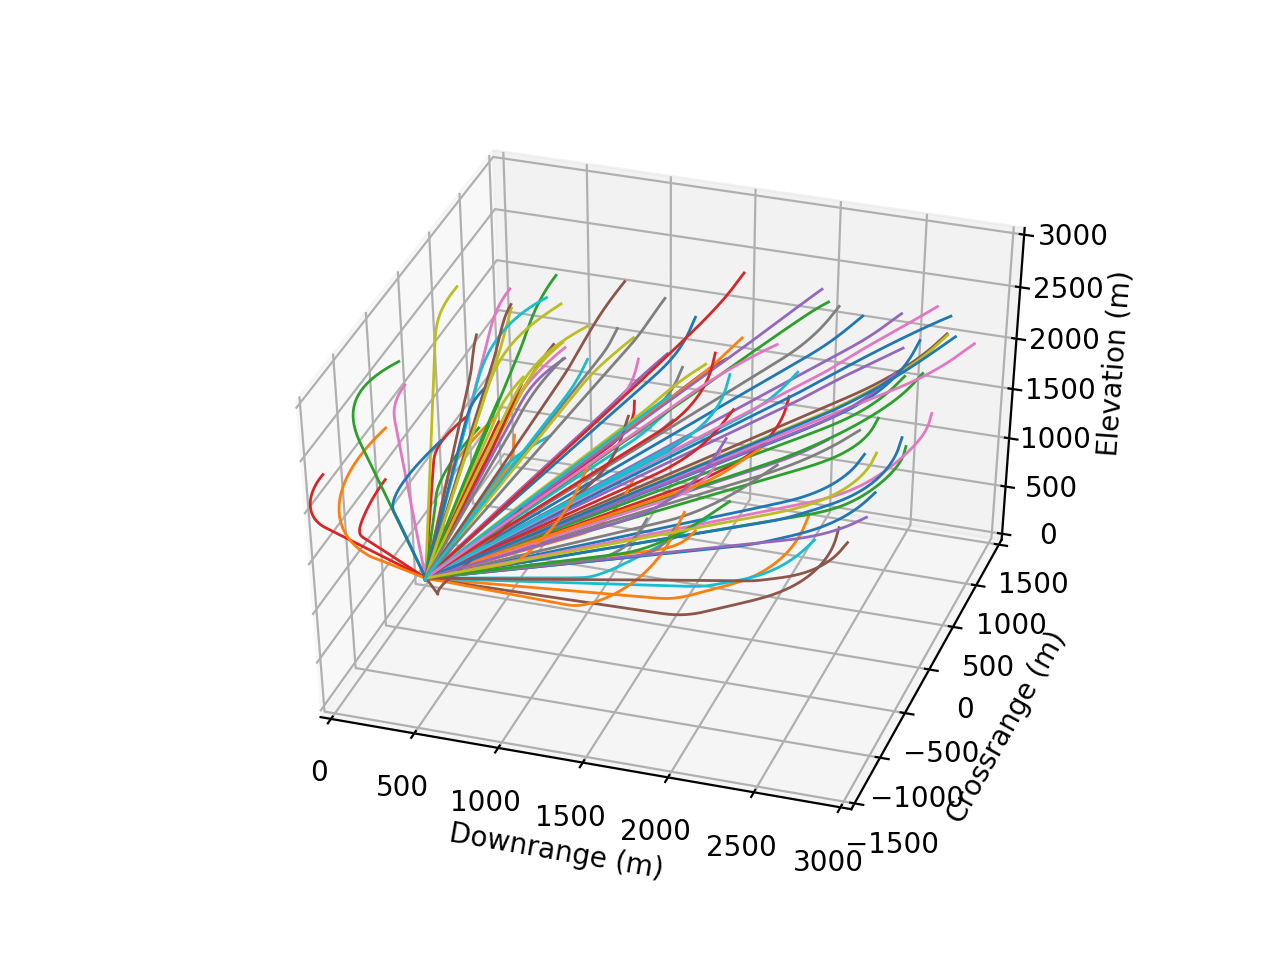

Text(0.0910982,0.0122048,'Elevation (m)')

In [16]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(11)
ax = fig.gca(projection='3d')

T = env.lander.trajectory_list[0:100]

for t in T:
    plot_traj(ax,t['position'],linewidth=1.0)
ax.legend
fig.canvas.draw()
plt.show()

ax.set_xlim3d(0,3000)
ax.set_ylim3d(-1500,1500)
ax.set_zlim3d(0,3000)

ax.set_xlabel('Downrange (m)')
ax.set_ylabel('Crossrange (m)')
ax.set_zlabel('Elevation (m)')


In [ ]:
np.save("trajectory_list.npy",T)

# 12 sq km 3000m

In [8]:
policy.test_mode=True
env.lander.divert=(0,0,0)
env.lander.apf_pot=env.lander.apf_pot2
env.attitude_constraint = Attitude_constraint(attitude_parameterization, 
                                          attitude_penalty=-100,attitude_coeff=-10,
                                         attitude_limit=(10*np.pi, np.pi, np.pi))
env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,4000 , -70, -10), 
                           crossrange = (-1500,1500 , -30,30),  
                           altitude = (2900,3100,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=100*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,20000,print_every=100)

Attitude Constraint
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9152.63 |3103.24 |3464.10 |20000.00 |    38
glideslope | 2.593 | 8.170 | 0.580 |820.407 |    11
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.5     0.1    -0.0 |     1.2     1.2     0.0 |    -1.7    -2.8    -0.1 |     3.1     2.4    -0.0
velocity |   0.068  -0.008  -0.884 |   0.028   0.039   0.135 |   0.007  -0.110  -1.177 |   0.134   0.093  -0.356
fuel     |344.41 | 33.29 |285.41 |419.20
attitude_321 |  -0.008  -0.016   0.004 |   0.165   0.010   0.012 |  -0.366  -0.039  -0.024 |   0.350   0.008   0.032
w        |   0.001  -0.010  -0.000 |   0.024   0.017   0.000 |  -0.057  -0.068  -0.000 |   0.064   0.037   0.000
glideslope |  23.044 |  14.968 |  10.218 |  95.127
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9173.99 |3128.16 |3464.10 |20000.00 |    38
glideslope | 2.625 | 8.097 | 0.580 |820.407 |    11
sc_margin |100.000 | 0.000 |100.000 |10

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9190.08 |3071.20 |3464.10 |20000.00 |    38
glideslope | 2.744 | 7.408 | 0.544 |1302.429 |   292
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.1     1.2     0.0 |    -2.6    -5.6    -0.1 |     5.2     2.4    -0.0
velocity |   0.065  -0.010  -0.903 |   0.027   0.039   0.126 |  -0.014  -0.134  -1.306 |   0.147   0.106  -0.347
fuel     |341.01 | 30.93 |284.83 |444.13
attitude_321 |  -0.033  -0.015   0.003 |   0.169   0.011   0.013 |  -0.547  -0.053  -0.051 |   0.401   0.012   0.043
w        |   0.000  -0.007   0.000 |   0.025   0.016   0.000 |  -0.087  -0.070  -0.000 |   0.087   0.039   0.000
glideslope |  22.950 |  17.099 |   7.855 | 296.915
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |9192.15 |3067.41 |3464.10 |20000.00 |  1235
glideslope | 2.742 | 7.405 | 0.544 |1302.429 |   292
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |9206.32 |3074.56 |3464.10 |20000.00 |  1235
glideslope | 2.732 | 7.512 | 0.544 |1302.429 |   292
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.1     1.2     0.0 |    -2.6    -5.6    -0.1 |     5.2     2.7    -0.0
velocity |   0.066  -0.010  -0.908 |   0.027   0.039   0.122 |  -0.041  -0.190  -1.306 |   0.147   0.125  -0.347
fuel     |340.91 | 31.03 |284.83 |444.13
attitude_321 |  -0.033  -0.015   0.002 |   0.170   0.011   0.013 |  -0.547  -0.060  -0.051 |   0.498   0.037   0.048
w        |   0.001  -0.008   0.000 |   0.025   0.015   0.000 |  -0.105  -0.088  -0.000 |   0.102   0.043   0.000
glideslope |  23.070 |  16.102 |   7.739 | 296.915
i :  2400
Cumulative Stats (mean,std,max,argmax)
thrust   |9202.57 |3068.74 |3464.10 |20000.00 |  1235
glideslope | 2.738 | 7.527 | 0.544 |1302.429 |   292
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |9207.11 |3060.64 |3464.10 |20000.00 |  1235
glideslope | 2.747 | 7.673 | 0.469 |2516.469 |  2807
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -2.7    -6.1    -0.1 |     5.9     2.7    -0.0
velocity |   0.066  -0.010  -0.908 |   0.027   0.039   0.121 |  -0.041  -0.190  -1.306 |   0.147   0.125  -0.347
fuel     |340.75 | 31.16 |283.45 |448.30
attitude_321 |  -0.033  -0.015   0.002 |   0.171   0.011   0.013 |  -0.547  -0.060  -0.051 |   0.498   0.037   0.048
w        |   0.000  -0.008  -0.000 |   0.024   0.016   0.000 |  -0.105  -0.088  -0.000 |   0.102   0.050   0.000
glideslope |  23.054 |  17.324 |   7.739 | 342.250
i :  3500
Cumulative Stats (mean,std,max,argmax)
thrust   |9205.24 |3059.25 |3464.10 |20000.00 |  1235
glideslope | 2.754 | 7.649 | 0.469 |2516.469 |  2807
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |9213.71 |3063.89 |3464.10 |20000.00 |  1235
glideslope | 2.781 | 9.576 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -2.9    -6.1    -0.1 |     5.9     3.0    -0.0
velocity |   0.066  -0.010  -0.908 |   0.027   0.039   0.122 |  -0.059  -0.190  -1.308 |   0.147   0.125  -0.330
fuel     |340.75 | 31.34 |283.45 |455.06
attitude_321 |  -0.031  -0.015   0.002 |   0.172   0.011   0.013 |  -0.547  -0.060  -0.051 |   0.498   0.037   0.060
w        |   0.000  -0.008   0.000 |   0.024   0.016   0.000 |  -0.105  -0.088  -0.000 |   0.112   0.093   0.000
glideslope |  23.059 |  18.049 |   7.480 | 342.250
i :  4600
Cumulative Stats (mean,std,max,argmax)
thrust   |9213.03 |3064.21 |3464.10 |20000.00 |  1235
glideslope | 2.778 | 9.518 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |9216.31 |3062.59 |3464.10 |20000.00 |  1235
glideslope | 2.804 | 9.719 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -2.9    -6.1    -0.1 |     5.9     3.0    -0.0
velocity |   0.065  -0.010  -0.908 |   0.027   0.039   0.122 |  -0.059  -0.201  -1.308 |   0.152   0.125  -0.315
fuel     |340.34 | 31.26 |283.45 |455.06
attitude_321 |  -0.033  -0.015   0.002 |   0.173   0.011   0.013 |  -0.547  -0.060  -0.051 |   0.498   0.037   0.060
w        |   0.001  -0.008   0.000 |   0.024   0.016   0.000 |  -0.105  -0.088  -0.000 |   0.112   0.093   0.000
glideslope |  23.474 |  22.647 |   7.135 | 901.826
i :  5700
Cumulative Stats (mean,std,max,argmax)
thrust   |9216.28 |3062.97 |3464.10 |20000.00 |  1235
glideslope | 2.805 | 9.666 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |9216.03 |3061.13 |3464.10 |20000.00 |  1235
glideslope | 2.821 | 9.681 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -2.9    -6.6    -0.1 |     5.9     3.0    -0.0
velocity |   0.065  -0.010  -0.909 |   0.027   0.039   0.121 |  -0.059  -0.201  -1.316 |   0.161   0.125  -0.315
fuel     |340.20 | 31.17 |283.45 |457.20
attitude_321 |  -0.032  -0.015   0.002 |   0.174   0.011   0.013 |  -0.547  -0.060  -0.051 |   0.498   0.037   0.060
w        |   0.001  -0.008   0.000 |   0.024   0.016   0.000 |  -0.105  -0.089  -0.000 |   0.117   0.093   0.000
glideslope |  23.534 |  22.769 |   7.135 | 901.826
i :  6800
Cumulative Stats (mean,std,max,argmax)
thrust   |9216.57 |3060.47 |3464.10 |20000.00 |  1235
glideslope | 2.823 | 9.650 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  7800
Cumulative Stats (mean,std,max,argmax)
thrust   |9213.54 |3061.13 |3464.10 |20000.00 |  1235
glideslope | 2.823 | 9.621 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -2.9    -6.6    -0.1 |     6.2     3.0    -0.0
velocity |   0.066  -0.010  -0.908 |   0.027   0.039   0.121 |  -0.059  -0.201  -1.316 |   0.161   0.125  -0.305
fuel     |340.18 | 31.11 |283.45 |457.20
attitude_321 |  -0.033  -0.015   0.002 |   0.174   0.011   0.013 |  -0.547  -0.062  -0.051 |   0.498   0.037   0.060
w        |   0.001  -0.008   0.000 |   0.024   0.016   0.000 |  -0.105  -0.089  -0.000 |   0.117   0.093   0.000
glideslope |  23.454 |  22.098 |   7.135 | 901.826
i :  7900
Cumulative Stats (mean,std,max,argmax)
thrust   |9212.90 |3058.98 |3464.10 |20000.00 |  1235
glideslope | 2.825 | 9.595 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  8900
Cumulative Stats (mean,std,max,argmax)
thrust   |9210.96 |3058.76 |3464.10 |20000.00 |  1235
glideslope | 2.836 | 9.806 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -2.9    -6.6    -0.1 |     6.2     3.0    -0.0
velocity |   0.065  -0.010  -0.908 |   0.027   0.039   0.122 |  -0.059  -0.201  -1.327 |   0.161   0.125  -0.305
fuel     |340.21 | 31.24 |283.45 |474.42
attitude_321 |  -0.032  -0.015   0.002 |   0.174   0.011   0.013 |  -0.547  -0.062  -0.051 |   0.518   0.037   0.062
w        |   0.001  -0.008   0.000 |   0.024   0.016   0.000 |  -0.118  -0.089  -0.000 |   0.117   0.093   0.000
glideslope |  23.396 |  21.405 |   6.663 | 901.826
i :  9000
Cumulative Stats (mean,std,max,argmax)
thrust   |9212.13 |3058.28 |3464.10 |20000.00 |  1235
glideslope | 2.835 | 9.777 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  10000
Cumulative Stats (mean,std,max,argmax)
thrust   |9211.16 |3060.10 |3464.10 |20000.00 |  1235
glideslope | 2.847 | 9.727 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -2.9    -6.6    -0.1 |     6.2     3.0    -0.0
velocity |   0.065  -0.010  -0.908 |   0.027   0.039   0.123 |  -0.059  -0.207  -1.327 |   0.161   0.140  -0.299
fuel     |340.19 | 31.26 |283.45 |474.42
attitude_321 |  -0.032  -0.015   0.002 |   0.174   0.011   0.013 |  -0.547  -0.062  -0.051 |   0.518   0.037   0.062
w        |   0.001  -0.008   0.000 |   0.024   0.016   0.000 |  -0.118  -0.089  -0.000 |   0.117   0.093   0.000
glideslope |  23.508 |  23.497 |   6.663 | 901.826
i :  10100
Cumulative Stats (mean,std,max,argmax)
thrust   |9212.00 |3059.60 |3464.10 |20000.00 |  1235
glideslope | 2.849 | 9.710 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  11100
Cumulative Stats (mean,std,max,argmax)
thrust   |9209.52 |3059.94 |3464.10 |20000.00 |  1235
glideslope | 2.844 | 9.670 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -2.9    -6.6    -0.1 |     6.2     3.0    -0.0
velocity |   0.065  -0.010  -0.908 |   0.027   0.039   0.123 |  -0.059  -0.207  -1.327 |   0.161   0.140  -0.299
fuel     |340.21 | 31.21 |282.08 |474.42
attitude_321 |  -0.032  -0.015   0.002 |   0.174   0.011   0.013 |  -0.547  -0.062  -0.051 |   0.525   0.054   0.062
w        |   0.001  -0.008   0.000 |   0.024   0.016   0.000 |  -0.156  -0.145  -0.000 |   0.117   0.093   0.000
glideslope |  23.579 |  24.291 |   6.663 | 901.826
i :  11200
Cumulative Stats (mean,std,max,argmax)
thrust   |9209.97 |3060.66 |3464.10 |20000.00 |  1235
glideslope | 2.845 | 9.663 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  12200
Cumulative Stats (mean,std,max,argmax)
thrust   |9210.20 |3059.99 |3464.10 |20000.00 |  1235
glideslope | 2.847 | 9.763 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -2.9    -6.6    -0.1 |     6.2     3.0    -0.0
velocity |   0.065  -0.010  -0.909 |   0.027   0.039   0.123 |  -0.059  -0.207  -1.327 |   0.161   0.140  -0.299
fuel     |340.26 | 31.21 |282.08 |474.42
attitude_321 |  -0.032  -0.015   0.002 |   0.174   0.011   0.013 |  -0.547  -0.062  -0.051 |   0.531   0.054   0.062
w        |   0.001  -0.008   0.000 |   0.024   0.016   0.000 |  -0.156  -0.145  -0.000 |   0.117   0.093   0.000
glideslope |  23.545 |  23.708 |   6.663 | 901.826
i :  12300
Cumulative Stats (mean,std,max,argmax)
thrust   |9210.43 |3060.47 |3464.10 |20000.00 |  1235
glideslope | 2.846 | 9.753 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  13300
Cumulative Stats (mean,std,max,argmax)
thrust   |9209.11 |3059.22 |3464.10 |20000.00 |  1235
glideslope | 2.854 | 9.728 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -2.9    -6.6    -0.1 |     6.2     3.0    -0.0
velocity |   0.065  -0.010  -0.909 |   0.027   0.040   0.123 |  -0.059  -0.207  -1.327 |   0.161   0.140  -0.299
fuel     |340.25 | 31.23 |282.08 |474.42
attitude_321 |  -0.032  -0.015   0.002 |   0.174   0.011   0.013 |  -0.553  -0.062  -0.051 |   0.531   0.054   0.062
w        |   0.001  -0.008   0.000 |   0.024   0.016   0.000 |  -0.156  -0.145  -0.000 |   0.117   0.093   0.000
glideslope |  23.738 |  28.928 |   6.663 |1930.354
i :  13400
Cumulative Stats (mean,std,max,argmax)
thrust   |9208.88 |3059.58 |3464.10 |20000.00 |  1235
glideslope | 2.854 | 9.706 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  14400
Cumulative Stats (mean,std,max,argmax)
thrust   |9207.78 |3059.47 |3464.10 |20000.00 |  1235
glideslope | 2.852 | 9.584 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -2.9    -6.6    -0.1 |     6.2     3.0    -0.0
velocity |   0.065  -0.010  -0.908 |   0.027   0.039   0.124 |  -0.059  -0.207  -1.327 |   0.161   0.140  -0.299
fuel     |340.30 | 31.26 |282.08 |474.42
attitude_321 |  -0.032  -0.015   0.002 |   0.174   0.011   0.013 |  -0.553  -0.062  -0.051 |   0.614   0.054   0.062
w        |   0.000  -0.008   0.000 |   0.024   0.016   0.000 |  -0.156  -0.145  -0.000 |   0.117   0.093   0.000
glideslope |  23.579 |  28.032 |   6.663 |1930.354
i :  14500
Cumulative Stats (mean,std,max,argmax)
thrust   |9207.83 |3059.68 |3464.10 |20000.00 |  1235
glideslope | 2.851 | 9.631 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  15500
Cumulative Stats (mean,std,max,argmax)
thrust   |9206.02 |3054.97 |3464.10 |20000.00 |  1235
glideslope | 2.860 | 9.509 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -3.0    -6.6    -0.1 |     6.2     3.0    -0.0
velocity |   0.066  -0.010  -0.908 |   0.027   0.039   0.124 |  -0.059  -0.207  -1.327 |   0.161   0.140  -0.212
fuel     |340.11 | 31.27 |282.08 |474.42
attitude_321 |  -0.032  -0.015   0.002 |   0.174   0.011   0.013 |  -0.553  -0.062  -0.051 |   0.614   0.054   0.062
w        |   0.000  -0.008   0.000 |   0.024   0.016   0.000 |  -0.156  -0.145  -0.000 |   0.117   0.093   0.000
glideslope |  23.465 |  27.372 |   6.663 |1930.354
i :  15600
Cumulative Stats (mean,std,max,argmax)
thrust   |9206.02 |3055.23 |3464.10 |20000.00 |  1235
glideslope | 2.859 | 9.496 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  16600
Cumulative Stats (mean,std,max,argmax)
thrust   |9207.19 |3055.19 |3464.10 |20000.00 |  1235
glideslope | 2.862 | 9.813 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -3.0    -6.6    -0.1 |     6.6     3.0    -0.0
velocity |   0.065  -0.010  -0.908 |   0.027   0.039   0.124 |  -0.059  -0.207  -1.327 |   0.161   0.140  -0.212
fuel     |340.09 | 31.31 |282.08 |474.42
attitude_321 |  -0.031  -0.015   0.002 |   0.174   0.011   0.013 |  -0.553  -0.062  -0.051 |   0.614   0.054   0.062
w        |   0.000  -0.008   0.000 |   0.024   0.016   0.000 |  -0.156  -0.145  -0.000 |   0.117   0.111   0.000
glideslope |  23.449 |  26.870 |   6.663 |1930.354
i :  16700
Cumulative Stats (mean,std,max,argmax)
thrust   |9207.67 |3055.09 |3464.10 |20000.00 |  1235
glideslope | 2.862 | 9.802 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  17700
Cumulative Stats (mean,std,max,argmax)
thrust   |9206.99 |3056.51 |3464.10 |20000.00 |  1235
glideslope | 2.854 | 9.672 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -3.0    -6.6    -0.1 |     6.6     3.0    -0.0
velocity |   0.065  -0.010  -0.908 |   0.027   0.039   0.124 |  -0.059  -0.207  -1.327 |   0.161   0.140  -0.212
fuel     |340.17 | 31.38 |282.08 |474.42
attitude_321 |  -0.032  -0.015   0.002 |   0.174   0.011   0.013 |  -0.553  -0.062  -0.051 |   0.614   0.054   0.062
w        |   0.001  -0.008   0.000 |   0.024   0.016   0.000 |  -0.156  -0.145  -0.000 |   0.117   0.111   0.000
glideslope |  23.449 |  26.732 |   6.663 |1930.354
i :  17800
Cumulative Stats (mean,std,max,argmax)
thrust   |9206.75 |3056.72 |3464.10 |20000.00 |  1235
glideslope | 2.854 | 9.655 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  18800
Cumulative Stats (mean,std,max,argmax)
thrust   |9207.51 |3054.60 |3464.10 |20000.00 |  1235
glideslope | 2.867 | 9.617 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -3.0    -6.6    -0.1 |     6.6     3.0    -0.0
velocity |   0.065  -0.010  -0.909 |   0.027   0.039   0.124 |  -0.059  -0.207  -1.327 |   0.161   0.140  -0.212
fuel     |340.05 | 31.34 |281.39 |474.42
attitude_321 |  -0.032  -0.015   0.002 |   0.174   0.011   0.013 |  -0.626  -0.062  -0.051 |   0.614   0.054   0.062
w        |   0.001  -0.008   0.000 |   0.024   0.016   0.000 |  -0.156  -0.145  -0.000 |   0.136   0.111   0.000
glideslope |  23.406 |  26.455 |   6.663 |1930.354
i :  18900
Cumulative Stats (mean,std,max,argmax)
thrust   |9207.29 |3054.71 |3464.10 |20000.00 |  1235
glideslope | 2.866 | 9.617 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  19900
Cumulative Stats (mean,std,max,argmax)
thrust   |9207.47 |3055.30 |3464.10 |20000.00 |  1235
glideslope | 2.870 | 9.623 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.1    -0.0 |     1.2     1.2     0.0 |    -3.0    -6.6    -0.1 |     6.6     3.0    -0.0
velocity |   0.065  -0.010  -0.909 |   0.027   0.039   0.124 |  -0.059  -0.207  -1.327 |   0.161   0.140  -0.212
fuel     |340.10 | 31.38 |281.39 |474.42
attitude_321 |  -0.033  -0.015   0.002 |   0.174   0.011   0.013 |  -0.626  -0.062  -0.051 |   0.614   0.054   0.062
w        |   0.001  -0.008   0.000 |   0.024   0.016   0.000 |  -0.156  -0.145  -0.000 |   0.136   0.111   0.000
glideslope |  23.468 |  26.805 |   6.663 |1930.354

Cumulative Stats (mean,std,max,argmax)
thrust   |9207.65 |3054.98 |3464.10 |20000.00 |  1235
glideslope | 2.872 | 9.630 | 0.469 |7288.516 |  4227
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Sta

In [13]:
policy.close_sess()
